# LIME - Local Interpretable Model-Agnostic Explanations

This assignment uses LIME, a package that provides "Locally Interpetable Model-agnostic Explanations" for machine learning models.

- **Locally interpretable**: for each specific prediction, we can provide a relevant explanation.
- **Model-agnostic**: we can provide the same sort of explanation for models of different classes.

For more documentation of the LIME package, see [here](https://github.com/marcotcr/lime) and [here](https://lime-ml.readthedocs.io/en/latest/index.html). The original paper describing the method is [here](https://arxiv.org/pdf/1602.04938.pdf).

In [1]:
!pip install lime # if you are running on JupyterLab, use !/opt/anaconda/bin/pip
!pip install xgboost

ERROR: Invalid requirement: '#'


In [2]:
%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
import lime
import lime.lime_tabular
from lime import submodular_pick
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict

import pandas as pd

np.random.seed(1)

***
## Part 1: Prepare the data

We will be using the Adult dataset which we can use to predict whether a person makes over 50K dollars per year based on census information. A version of the dataset is found on UCI ML Repository : [here](https://archive.ics.uci.edu/ml/datasets/adult).

### Read in the data

In [3]:
# Read in the data
colnames = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
            "Marital-Status", "Occupation", "Relationship", "Race", "Sex",
            "Capital-Gain", "Capital-Loss","Hours-per-week", "Country",
            "income"]
data_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                      names = colnames)
print("Shape: ", data_df.shape)
data_df.head()

Shape:  (32561, 15)


,Age,Workclass,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Clean the data

In [4]:
# TODO - Drop Education-Num, which has a functional dependency with Education

data_df = data_df.drop('Education-Num', axis=1)
print("Shape: ", data_df.shape)
data_df.head()


Shape:  (32561, 14)


,Age,Workclass,fnlwgt,Education,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Get a list of feature names (excluding the outcome variable)
feature_names = data_df.columns[:-1]

In [6]:
# Mark labels and encode them using sklearn
labels = data_df.iloc[:,-1]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data_df.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [' <=50K' ' >50K']
Label mapping:  {' <=50K': 0, ' >50K': 1}


In [7]:
# Check if there are categorical variables that we need to make dummies for
print(data.dtypes)
# Get a list of which variables are categorical
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
dtype: object
Indices of categorical features:  [1, 3, 4, 5, 6, 7, 8, 12]


C:\Users\Peter\AppData\Local\Temp\ipykernel_9464\408250832.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
C:\Users\Peter\AppData\Local\Temp\ipykernel_9464\408250832.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
C:\Users\Peter\AppData\Local\Temp\ipykernel_9464\408250832.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

LIME will require us to provde categorical variables as a single column, not as dummies, so we can't just explode these columns the way we normally would during pre-processing.

Instead, we'll use some sklearn tools to take the following steps:
1. Encode the existing categories with a number corresponding to each category
2. Make a dictionary storing the relationship between the original string category and the number we've replaced it with (categorical_names)
3. Make a function that we can use down the line to transform categorical variables into dummies

In [8]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    # Use label encoder to map categories to numbers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")

Feature:  1
[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
Feature:  3
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
Feature:  4
[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
Feature:  5
[' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
Feature:  6
[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
Feature:  7
[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
Feature:  8
[' Female' ' Male']
Feature:  12
[' ?' ' Cambodia' ' Canada' ' Chi

In [9]:
# This variable is where we store the original names of each category for each variable
categorical_names

{1: array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 3: array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 4: array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 5: array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 6: array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
     

In [10]:
# We can (and will) use this encoder function to transform the categorical columns into dummies--
# but we can't do that to the original dataset if we want to use LIME
encoder = ColumnTransformer(transformers=[('get_dummies', OneHotEncoder(), categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

### Split into training and test sets




In [11]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80, random_state=10)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)


Train shape:  (26048, 13)
Test shape:  (6513, 13)


***
## Part 2: Train a model

We will be using gradient boosted decision trees as implemented by the [xgboost](https://github.com/dmlc/xgboost) package.

In [12]:
# Fit the model
gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
gbtree.fit(encoder.transform(train), labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
# Make predictions
pred_labels_test = gbtree.predict(encoder.transform(test))

# Calculate accuracy on the test set
print("Test set accuracy: ", sklearn.metrics.accuracy_score(labels_test, pred_labels_test))

Test set accuracy:  0.866421004145555


***
## Part 3: Explaining predictions the usual way



### **Questions:**
*Hint:* Google is your best friend!
1. How would you normally explain the predictions of a single decision tree?

    **Write answer here:** Prediction of a single decision tree are made with mutiple factors. I would first analyze the structure, noting decision nodes, leaf nodes, and the root node as well as understanding how deep the tree goes. Predicitons are made by the path choices made at a decision node and understanding the feature importance at every level when traversing the tree until the leaf node. The only difficulty with a prediciton of a single decision tree would be the problem of overfitting. 


2. What is a gradient boosted decision tree?

    **Write answer here:** Unlike a single decision tree, a gradient boosting decision tree utilizes gradient boosting with a sequence of decision trees in a ensemble, building a better tree compared to the previous through iterations that has better testing accuracy. At the end of training, the model would produce a decision tree with more accurate prediction performance.  

3. Does that change for a gradient boosted decision tree?

    **Write answer here:** Yes, using a gradient boosted decision tree is more effective and more powerful for building a model that is more predictive accurate compared to a single decision tree.



We're going to be looking at a measure of feature importance. This is calculated for a single tree by counting how many splits occured on each variable. We arrive at a feature importance for the entire model by averaging the score for each feature across all trees in the forest.


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

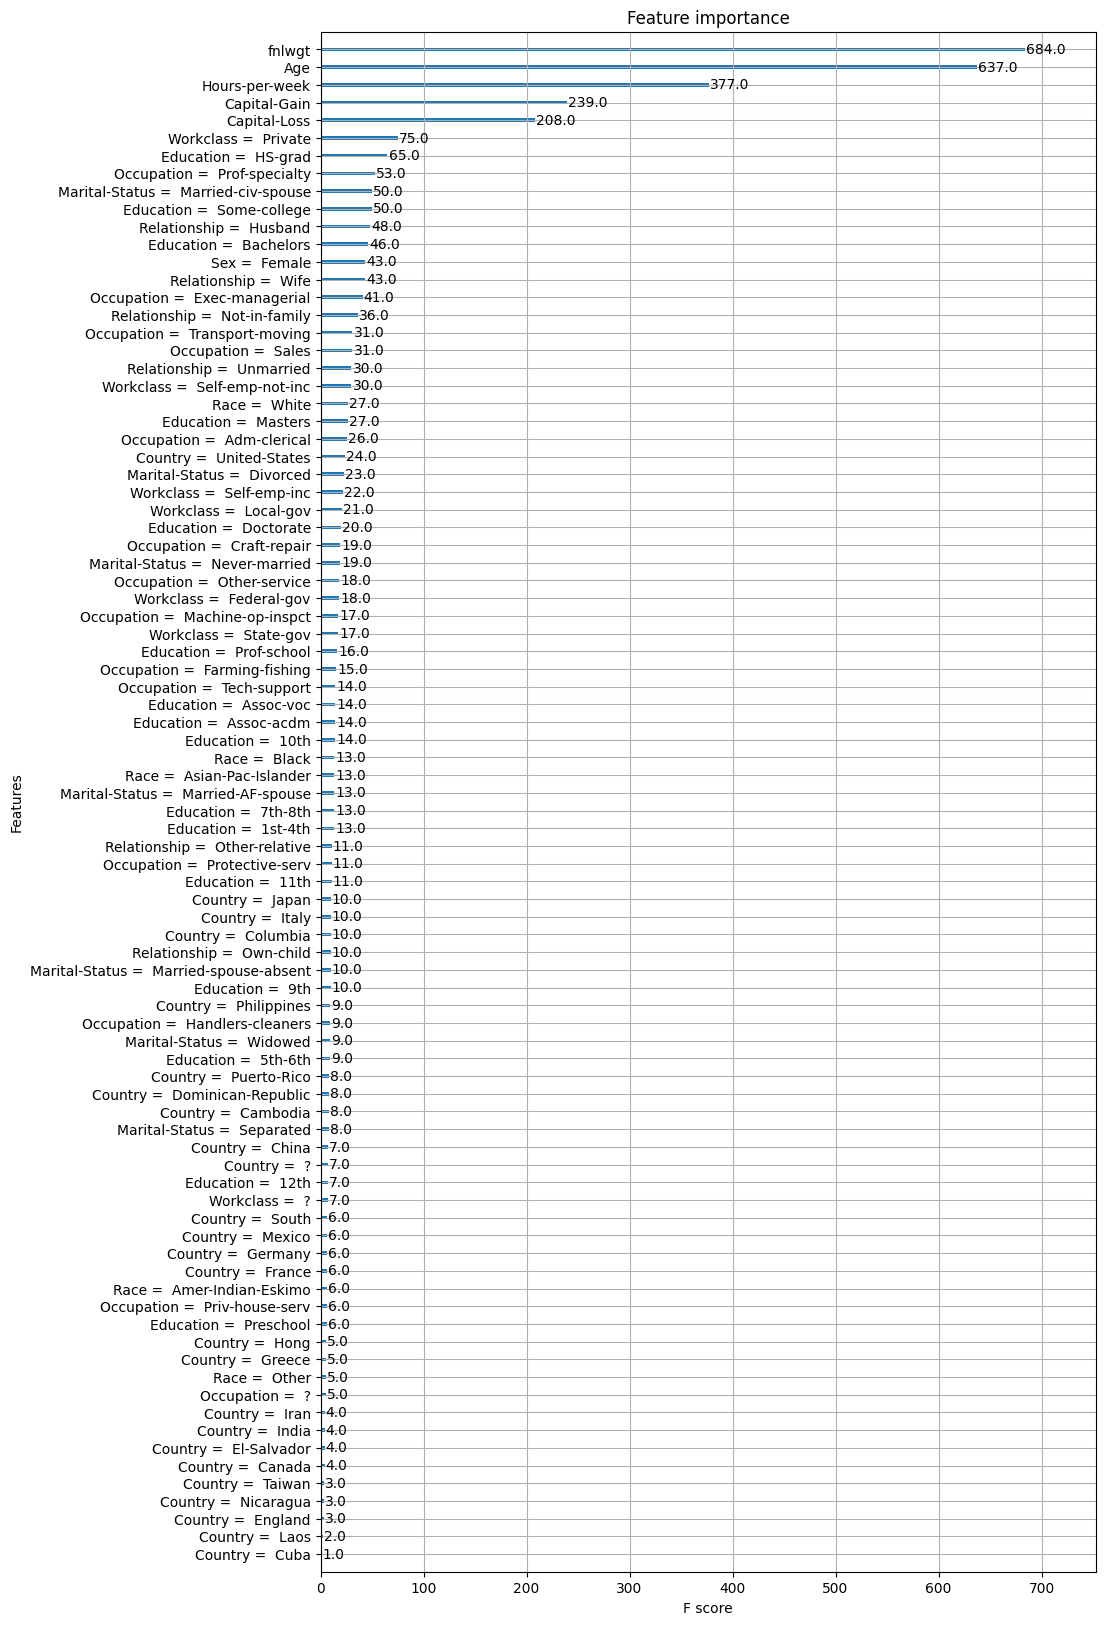

In [14]:
# Get feature names for the transformed dataset so that they'll show up on the plot -- don't worry about this bit
gbtree_features_orig = gbtree.get_booster().feature_names
gbtree_features = []
for cat_var in categorical_names:
    cat_var_names = [feature_names[cat_var] +" = " + cat for cat in categorical_names[cat_var]]
    gbtree_features.extend(cat_var_names)
gbtree_features.extend([feature_names[i] for i in range(len(feature_names)) if i not in categorical_features])
gbtree.get_booster().feature_names = gbtree_features

# Plot feature importances
plt.rcParams["figure.figsize"] = (10,20)
plot_importance(gbtree.get_booster())

Pick an interesting feature with a high importance in the plot above. Can you figure out the relationship of that feature with the outcome variable? (Is a higher or lower value more likely to indicate a high-income individual? For binary variables, is it 0 or 1?) 

Answer: One of the high features of importance is age. Notice that the older population have higher include which likely indicates experience and seniority which would lead to higher income compared to a student or younger age in the distribution. 

In [15]:

high_income_avg_age = data_df[data_df['income'] == 1]['Age'].mean()

low_income_avg_age = data_df[data_df['income'] == 0]['Age'].mean()


The plot_importance function takes a parameter called 'importance_type', which you can read more about [in the documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting). Try changing the importance type and re-making the plot. How does our explanation change?

When I select the gain as the important feature here, the feture importance is different where martial status shows the most important feature after modifying the importance type.

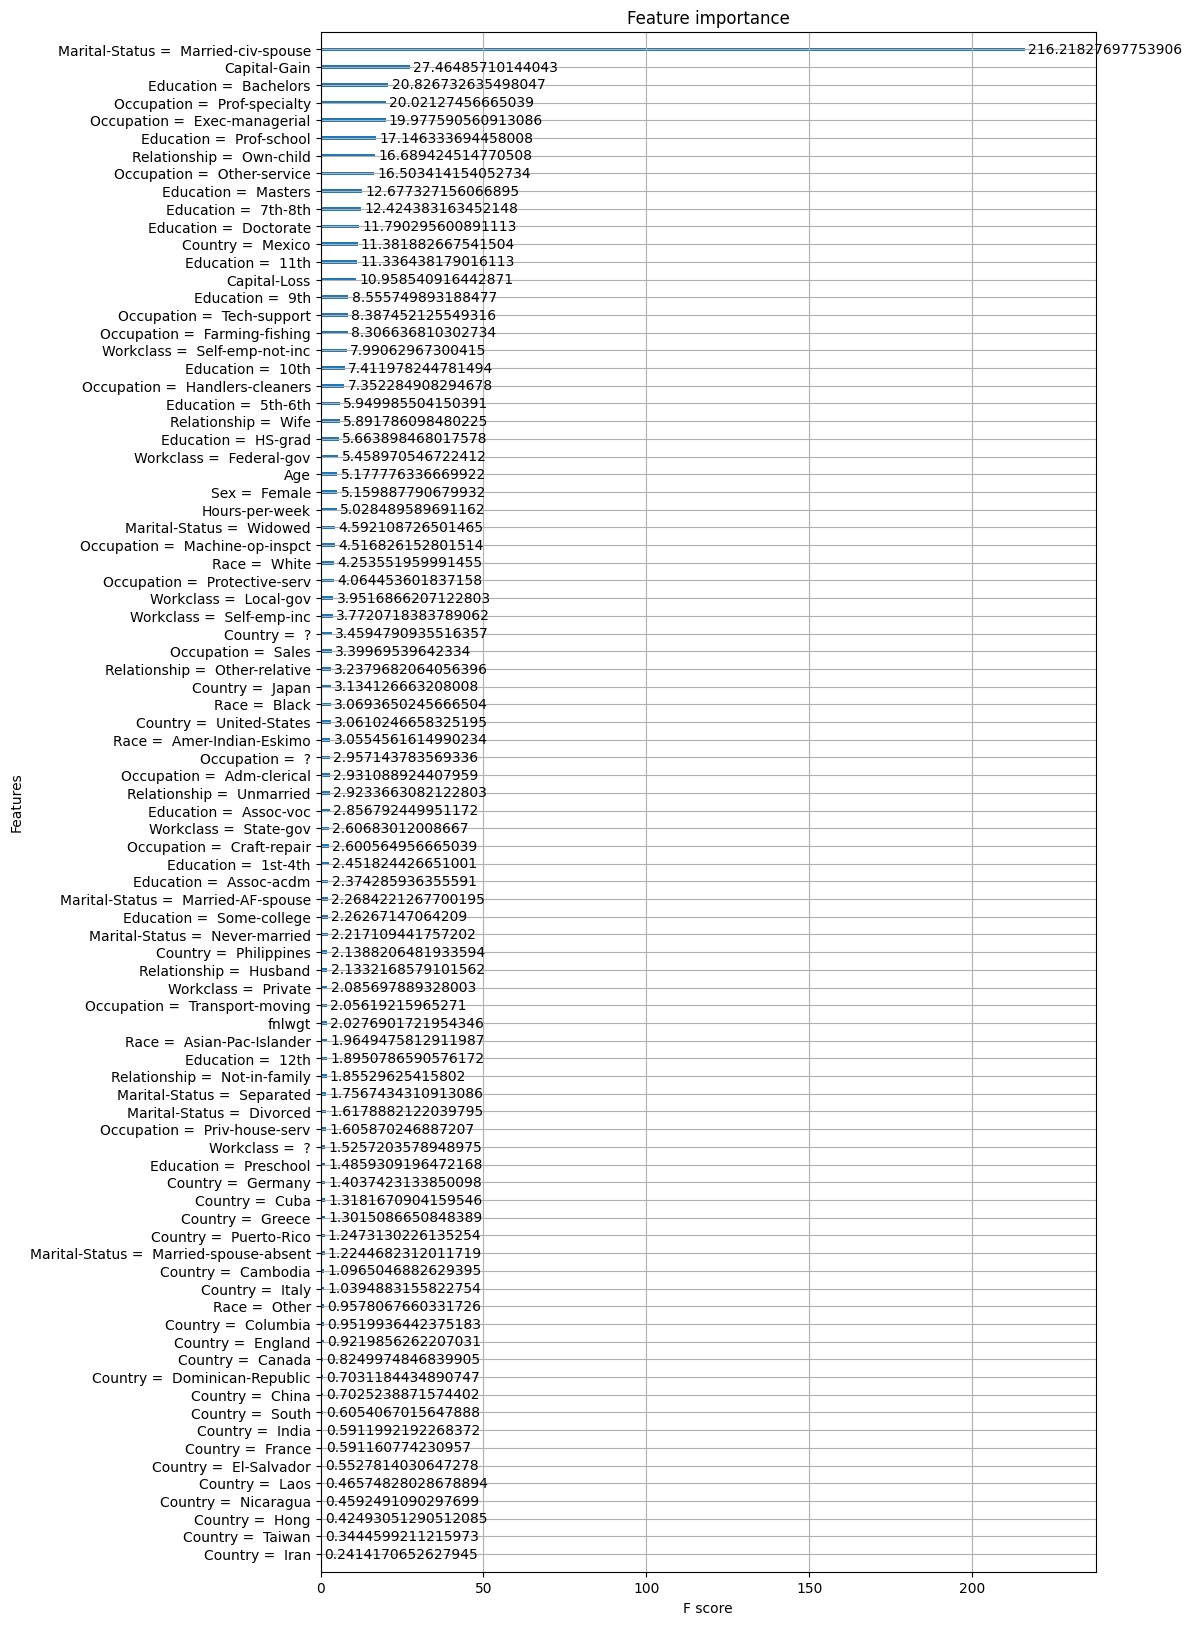

In [41]:
import xgboost as xgb
gbtree_features_orig = gbtree.get_booster().feature_names
gbtree_features = []
for cat_var in categorical_names:
    cat_var_names = [feature_names[cat_var] +" = " + cat for cat in categorical_names[cat_var]]
    gbtree_features.extend(cat_var_names)
gbtree_features.extend([feature_names[i] for i in range(len(feature_names)) if i not in categorical_features])
gbtree.get_booster().feature_names = gbtree_features


importance_type = 'gain'

plt.rcParams["figure.figsize"] = (10, 20)
xgb.plot_importance(gbtree.get_booster(), importance_type=importance_type)
plt.show()

In [42]:
# Replace the original feature names, which LIME will expect
gbtree.get_booster().feature_names = gbtree_features_orig

***
## Part 4: Explaining predictions with LIME

Time for LIME!

### LIME Tabular Explainer

The tabular explainer is how we get locally interpretable explanations for classification problems.

First, we initialize an explainer object that takes in all the information we stored/encoded earlier about the dataset.

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names)

Next, we need to define a single function that takes in the form of data that LIME expects and returns the type of prediction that LIME expects. In particular,
- the input should be a numpy array (which we can get from a pandas df using .values)
- the input features should be human-understandable
- the input data should have each categorical variable in a single column
- the output should be a predicted probability (not a predicted class)

In [44]:
predict_fn = lambda x: gbtree.predict_proba(encoder.transform(x)).astype(float)

Now we have everything we need to use the explainer. Let's get an explanation for one of the examples in the test set.

In [45]:
i = 3
print('Actual class: ', labels_test[i])
# Get explanation
exp = explainer.explain_instance((test.values[i]), predict_fn, num_features=5)

Actual class:  0


c:\Users\Peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [39]:
# Visualize the explanation
%matplotlib inline
fig = exp.as_pyplot_figure()

NameError: name 'exp' is not defined

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs. You could also save the html page to a file if you wanted to.

In [17]:
exp.show_in_notebook(show_all=True)

NameError: name 'exp' is not defined

The explanation can also be presented as a list of weighted features.

In [ ]:
exp.as_list()

### **Questions:**
4. How do we interpret this plot? That is, what do red and green mean? What's on the x axis?

    **Write answer here:**

5. How does this explanation differ from the feature importance explanation given above?

    **Write answer here:**


### **TODO - Generate LIME explanations (in whichever format you chose) for some other examples in the test set. Are similar features important? Add text + code cells below**

### LIME Submodular Picker

As we just saw, explanations can vary a lot depending on what instance we pick. While this is great for explaining a single prediction, it makes it hard to give someone general intuition for "how the model makes decisions." That's where the submodular picker comes in. It picks useful, representative examples that together give global explanation for the model.

In broad strokes, the algorithm does the following:
1. Calculate an explanation for all examples in the dataset
2. Determine which features are important in explaining a lot of predictions -- that is, features that seem globally important
3. Select (greedily) examples where the top globally important feature is part of the local explanation for that one example's prediction
3. Continue selecting examples until we've covered as many of the globally important features as possible, constrained by the number of features that the user wants returned (num_exps_desired)

You can read the details of how this is done in the paper.

In [ ]:
# Initialize the SP object
sp_obj = submodular_pick.SubmodularPick(explainer, train.values, predict_fn, sample_size=10,
                                        num_features=5, num_exps_desired=5)

The attribute V tells us the best indices from the test set to explain the overall predictions of the classifier.

In [ ]:
sp_obj.V

Now, we can get explantions for each of those examples:

In [ ]:
for ind in sp_obj.V:
    exp = explainer.explain_instance(test.values[ind], predict_fn, num_features=5)
    print("Actual class: ", labels_test[ind])
    exp.show_in_notebook(show_all=False)
    print("==========================")

### **Question:**

6. Based on these carefully chosen examples, what would you say to someone who wanted to know how our model makes decisions?

    **Write answer here:**
